In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import random,shutil

(256, 1600, 3)

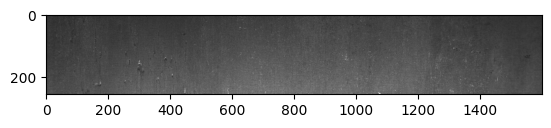

In [6]:
img = cv2.imread('/kaggle/input/severstal-steel-defect-detection/train_images/000a4bcdd.jpg')
plt.imshow(img)
img.shape

In [7]:
df = pd.read_csv('/kaggle/input/severstal-steel-defect-detection/train.csv')

In [8]:
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [ ]:
df['ClassId'].unique()

In [ ]:
# /kaggle/input/severstal-steel-defect-detection/train_images/008621629.jpg
df[df['ImageId']=='008621629.jpg']

In [ ]:
a = df.iloc[16]['EncodedPixels']

In [16]:
# 1) RLE → mask
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.array(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    flat = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        flat[lo:hi] = 1
    return flat.reshape(shape, order='F')

# 2) mask → bbox
def mask_to_bbox(mask):
    ys, xs = np.where(mask)
    if len(xs)==0:
        return None
    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ys.min(), ys.max()
    return xmin, ymin, xmax, ymax
    
# 3) bbox → YOLO format
def bbox_to_yolo(xmin, ymin, xmax, ymax, img_w, img_h):
    box_w = xmax - xmin
    box_h = ymax - ymin
    x_c = xmin + box_w/2
    y_c = ymin + box_h/2
    return x_c/img_w, y_c/img_h, box_w/img_w, box_h/img_h



In [ ]:
img = Image.open('/kaggle/input/severstal-steel-defect-detection/train_images/008621629.jpg')
img_w,img_h = img.size

In [ ]:
plt.imshow(img)

In [ ]:
k = rle_decode(a,shape=(img_h,img_w))
plt.imshow(k)

In [ ]:
df = pd.read_csv('/kaggle/input/severstal-steel-defect-detection/train.csv')
image_size = (1600, 256)  # Severstal images are 256×1600 (H×W)

for img_id, group in df.groupby('ImageId'):
    lines = []
    for _, row in group.iterrows():
        cl = int(row.ClassId) - 1
        if pd.isna(row.EncodedPixels):
            continue
        mask = rle_decode(row.EncodedPixels, image_size)
        bbox = mask_to_bbox(mask)
        if bbox is None:
            continue
        yolo_box = bbox_to_yolo(*bbox, img_w=image_size[1], img_h=image_size[0])
        lines.append(f"{cl} " + " ".join(f"{v:.6f}" for v in yolo_box))
    # save if there is at least one defect
    if lines:
        os.makedirs('labels/train', exist_ok=True)
        with open(f"labels/train/{img_id[:-4]}.txt", 'w') as f:
            f.write("\n".join(lines))

In [ ]:
for k in os.listdir('/kaggle/working/labels/train'):
    print(k)
    break

In [ ]:
len(os.listdir('/kaggle/working/labels/train'))

In [ ]:
folders = ['train/images','train/labels','valid/images','valid/labels']
!cd /kaggle/working/
for folder in folders:
    os.makedirs(folder,exist_ok=True)

In [ ]:
SRC_IMG_DIR = '/kaggle/input/severstal-steel-defect-detection/train_images'
SRC_LABEL_DIR = '/kaggle/working/labels/train'

# Your existing YOLO structure
YOLO_BASE    = '/kaggle/working'
TRAIN_IMG_DIR = os.path.join(YOLO_BASE, 'train/images')
TRAIN_LBL_DIR = os.path.join(YOLO_BASE, 'train/labels')
VAL_IMG_DIR   = os.path.join(YOLO_BASE, 'valid/images')
VAL_LBL_DIR   = os.path.join(YOLO_BASE, 'valid/labels')

In [ ]:
all_imgs = sorted(fname for fname in os.listdir(SRC_IMG_DIR)
                  if fname.lower().endswith(('.jpg','.png','jpeg')))

random.seed(42)
random.shuffle(all_imgs)
split = int(0.8 * len(all_imgs))
train_imgs, valid_imgs = all_imgs[:split], all_imgs[split:]

def distribute(img_list, dst_img_dir, dst_lbl_dir):
    for img in img_list:
        base = os.path.splitext(img)[0]
        # copy image
        shutil.copy(
            os.path.join(SRC_IMG_DIR, img),
            os.path.join(dst_img_dir, img)
        )
        # copy label if exists, else empty file
        src_lbl = os.path.join(SRC_LABEL_DIR, base + '.txt')
        dst_lbl = os.path.join(dst_lbl_dir,   base + '.txt')
        if os.path.exists(src_lbl):
            shutil.copy(src_lbl, dst_lbl)
        else:
            open(dst_lbl, 'w').close()

# 3) Populate folders
distribute(train_imgs, TRAIN_IMG_DIR, TRAIN_LBL_DIR)
distribute(valid_imgs, VAL_IMG_DIR,   VAL_LBL_DIR)

print(f"Done: {len(train_imgs)} train / {len(valid_imgs)} valid images.")   

In [ ]:
yaml_content = """\
train: /kaggle/working/train/images
val:   /kaggle/working/valid/images

nc: 4
names:
  0: 1
  1: 2
  2: 3
  3: 4
"""

# Save to steel.yaml in current working directory
yaml_path = 'steel.yaml'
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"Created YAML file at {os.path.abspath(yaml_path)} with content:\n")
print(yaml_content)

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

In [ ]:
model = YOLO('yolov8n.pt')

In [ ]:
# results = model.train(
#     data='steel.yaml',    # path to the YAML we created
#     epochs=50,            # number of epochs
#     imgsz=640,            # image size
#     batch=16,             # batch size
#     # lr=0.01,              # starting learning rate
#     patience=10,          # early stopping patience
#     # project='runs/train', # where to save results
#     # name='steel_yolov8s'  # folder name under runs/train
# )

In [ ]:
# results = model.train(
#     data='steel.yaml',      # our dataset config
#     epochs=100,             # more epochs for convergence
#     imgsz=640,              # training image size
#     batch=16,               # batch size
#     patience=20,            # early stopping patience

#     # —————— Augmentations ——————
#     augment=True,           # enable default augment pipeline
#     mosaic=True,            # mix 4 images into one
#     mixup=0.5,              # mixup augmentation
#     hsv_h=0.015,            # hue augmentation (±1.5%)
#     hsv_s=0.7,              # saturation augmentation (±70%)
#     hsv_v=0.4,              # value augmentation (±40%)
#     degrees=2.0,            # image rotation (±2°)
#     translate=0.1,          # image translation (±10%)
#     scale=0.5,              # image scale (±50%)
#     shear=2.0,              # shear (±2°)
#     perspective=0.0,        # perspective transformation
#     flipud=0.0,             # vertical flip probability
#     fliplr=0.5,             # horizontal flip probability

#     # —————— Optimizer & LR schedule ——————
#     optimizer='AdamW',      # switch to AdamW for faster convergence
#     lr0=0.001,              # initial learning rate
#     lrf=0.01,               # final learning rate = lr0 * lrf
#     momentum=0.937,         # SGD momentum (not used by AdamW)
#     weight_decay=0.0005,    # optimizer weight decay

#     # —————— Other training tweaks ——————
#     cache=True,             # cache images for faster epoch loops
#     workers=4,              # number of dataloader workers
#     val=True,               # run validation at each epoch
#     # device=0                # GPU id (or '0,1' for multi-GPU)
# )

Segmentation

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python matplotlib

In [ ]:
import torch
from segment_anything import sam_model_registry, SamPredictor

In [ ]:
# Choose SAM model type (vit_h is large but accurate, vit_b is faster)
sam_checkpoint = "/kaggle/input/vit-checkpoint/other/default/1/sam_vit_b_01ec64.pth"  # Upload model manually if needed
model_type = "vit_b"  # or "vit_h", "vit_l"

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = sam.to(device)

In [ ]:
sam

In [ ]:
predictor = SamPredictor(sam)

In [ ]:
img = '/kaggle/input/severstal-steel-defect-detection/train_images/0002cc93b.jpg'
bbox = '/kaggle/working/labels/train/0002cc93b.txt'

In [ ]:
image = cv2.imread(img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape
predictor.set_image(image)
image_embedding = predictor.get_image_embedding().cpu().numpy()


In [ ]:
def yolo_to_xyxy(yolo_box, img_w, img_h):
    cls, x_c, y_c, bw, bh = yolo_box
    x1 = int((x_c - bw / 2) * img_w)
    y1 = int((y_c - bh / 2) * img_h)
    x2 = int((x_c + bw / 2) * img_w)
    y2 = int((y_c + bh / 2) * img_h)
    return [x1, y1, x2, y2]

In [ ]:
# Read YOLO boxes from .txt
boxes = []
with open(bbox, 'r') as f:
    for line in f.readlines():
        parts = list(map(float, line.strip().split()))
        box = yolo_to_xyxy(parts, w, h)
        boxes.append(box)

In [ ]:
# Convert to torch and transform
boxes_np = np.array(boxes)
transformed_boxes = predictor.transform.apply_boxes_torch(
    torch.tensor(boxes_np, dtype=torch.float32), image.shape[:2]
).to(device)

In [ ]:
transformed_boxes

In [ ]:
# --- Predict masks
masks, scores, logits = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False
)

In [ ]:
# --- Visualize
for i, mask in enumerate(masks):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.imshow(mask[0].cpu(), alpha=0.5)
    x1, y1, x2, y2 = boxes[i]
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                      edgecolor='red', facecolor='none', linewidth=2))
    plt.title(f"Box {i} + SAM Mask")
    plt.axis('off')
    plt.show()

Segmentation - Without SAM

In [9]:
df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [10]:
grouped = df.groupby('ImageId')['EncodedPixels'].apply(list).reset_index()

In [11]:
#Create masks
def create_mask(image_id, encoded_pixels_list, shape=(256, 1600)):
    mask = np.zeros(shape,dtype=np.uint8)
    for rle in encoded_pixels_list:
         if isinstance(rle, str):  # Make sure it's not NaN
            mask += rle_decode(rle, shape)
    return np.clip(mask, 0, 1)  # In case of overlapping masks

In [12]:
#Create dataset

from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
class SteelDefectDataset(Dataset):
    def __init__(self, dataframe, image_dir, image_shape=(256, 1600), transform=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.image_shape = image_shape

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['ImageId']
        encoded_pixels = row['EncodedPixels']

        # Load image
        image_path = os.path.join(self.image_dir, image_id)
        image = Image.open(image_path).convert("RGB")

        # Resize if needed
        if image.size != self.image_shape[::-1]:  # Pillow uses (width, height)
            image = image.resize(self.image_shape[::-1])

        # Create and resize mask
        mask = create_mask(image_id, encoded_pixels, shape=self.image_shape)
        mask = Image.fromarray(mask).resize(self.image_shape[::-1])
        mask = np.array(mask)

        # Apply transforms to image
        if self.transform:
            image = self.transform(image)

        # Convert mask to tensor (add channel dim)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask


In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0,1] and CHW format
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [29]:
from torch.utils.data import DataLoader,Dataset

In [30]:
dataset = SteelDefectDataset(dataframe=grouped, image_dir='/kaggle/input/severstal-steel-defect-detection/train_images', transform=transform)
train_loader = DataLoader(dataset,batch_size=16,shuffle=True)


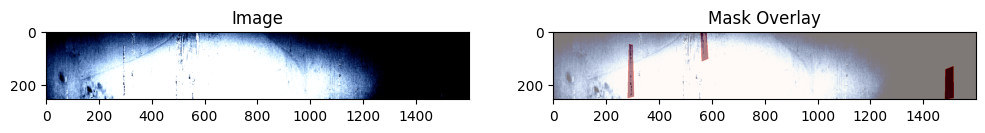

In [31]:
import matplotlib.pyplot as plt

# Get a sample
image, mask = dataset[15]

# Convert image tensor to numpy for plotting
img_np = image.permute(1, 2, 0).numpy()
mask_np = mask.squeeze().numpy()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(img_np)
plt.imshow(mask_np, alpha=0.5, cmap='Reds')
plt.title('Mask Overlay')
plt.show()


In [32]:
!pip install segmentation-models-pytorch


In [20]:
import segmentation_models_pytorch as smp


In [21]:
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder
    encoder_weights="imagenet",     # use ImageNet pre-trained weights
    in_channels=3,                  # RGB input
    classes=4,                      # segmentation
)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [35]:
device = 'cuda'
model = model.to('cuda')

In [36]:
import torch
import torch.nn as nn

In [37]:
from torch.optim import Adam
epochs = 1
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(),lr = 1e-4)

In [ ]:
train_losses = []
val_losses = []
val_dice_scores = []

for epoch in range(epochs):
    model.train()
    train_loss = 0 
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        pred = model(images)
        loss = loss_fn(pred, masks)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Train loss for epoch {epoch}: {avg_train_loss:.4f}")

    model.eval()
    val_loss = 0.0
    dice_scores = []
    with torch.no_grad():
        for images, masks in valid_loader:
            images, masks = images.to(device), masks.to(device)
            pred = model(images)
            loss = loss_fn(pred, masks)
            val_loss += loss.item()
        
            preds = torch.sigmoid(pred)
            preds = (preds > 0.5).float()
            intersection = (preds * masks).sum(dim=(1,2,3))
            union = preds.sum(dim=(1,2,3)) + masks.sum(dim=(1,2,3))
            dice = (2. * intersection + 1e-7) / (union + 1e-7)
            dice_scores.extend(dice.cpu().numpy())
        
    avg_val_loss = val_loss / len(valid_loader)
    avg_dice = sum(dice_scores) / len(dice_scores)
    val_losses.append(avg_val_loss)
    val_dice_scores.append(avg_dice)

    print(f"Validation Loss: {avg_val_loss:.4f} | Dice Score: {avg_dice:.4f}")